In [142]:
!pip install hypernetx
!pip install gudhi
!pip install ripser
!pip install persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.1 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=042db59d55b24415a5b930f4900d54696859c83ea19bd6441aaf3ceb4a6b590c
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [119]:
import numpy as np
import kagglehub
import os
from collections import defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import hypernetx as hnx
import struct
from tqdm import tqdm
import gudhi as gd

In [3]:
if not os.path.exists("/content/data"):
  !kaggle datasets download -d hojjatk/mnist-dataset -p /content
  !unzip /content/mnist-dataset.zip -d /content/data
  !rm /content/mnist-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 54% 12.0M/22.0M [00:00<00:00, 124MB/s]
100% 22.0M/22.0M [00:00<00:00, 169MB/s]
Archive:  /content/mnist-dataset.zip
  inflating: /content/data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: /content/data/t10k-images.idx3-ubyte  
  inflating: /content/data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: /content/data/t10k-labels.idx1-ubyte  
  inflating: /content/data/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: /content/data/train-images.idx3-ubyte  
  inflating: /content/data/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: /content/data/train-labels.idx1-ubyte  


In [15]:
pixelThreshold = 100

In [4]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Assuming the file is in the /content/mnist-dataset directory
images = read_idx('/content/data/train-images-idx3-ubyte/train-images-idx3-ubyte')
labels = read_idx('/content/data/train-labels-idx1-ubyte/train-labels-idx1-ubyte')

print(images.shape)  # Print the shape of the image data
print(labels.shape)  # Print the shape of the label datan

(60000, 28, 28)
(60000,)


In [110]:
allEdges = []
for i in tqdm(range(len(images))):
    edges = np.where(images[i].flatten() > pixelThreshold)[0]
    edgesPairedWithZero = np.stack([np.full_like(edges, labels[i]), edges], axis=1)

    allEdges.append(edgesPairedWithZero)

allEdges = np.concatenate(allEdges)

100%|██████████| 60000/60000 [00:02<00:00, 21859.34it/s]


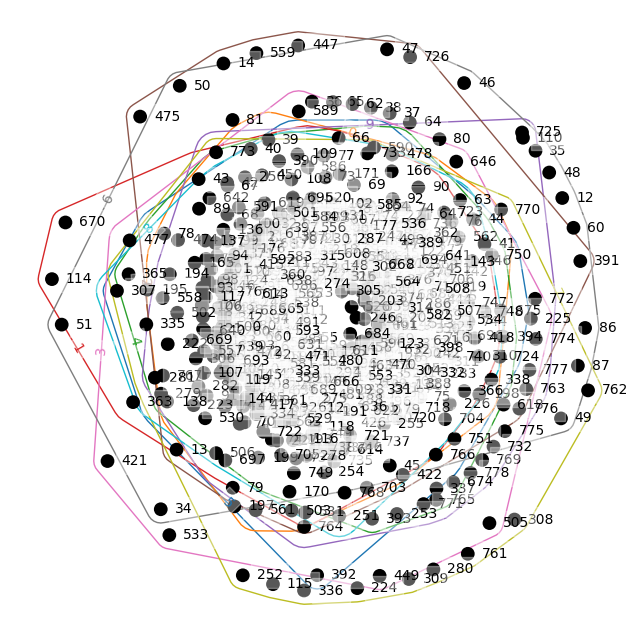

In [111]:
H = hnx.Hypergraph(allEdges)
hnx.draw(H)

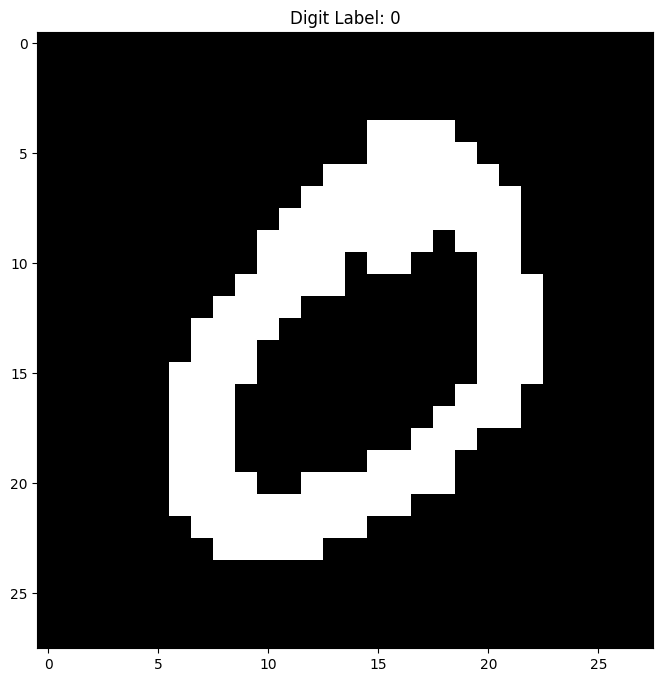

In [126]:
# Convert image to binary (thresholded)
def binarize_image(image, threshold=50):
    return (image > threshold).astype(int)

imageIdx = 1
# Get a sample image
sample_image = binarize_image(images[imageIdx])

# Show the thresholded image
plt.imshow(sample_image, cmap="gray")
plt.title(f"Digit Label: {labels[imageIdx]}")
plt.show()

In [127]:
def image_to_simplicial_complex(image):
    st = gd.SimplexTree()

    # Get active pixel positions
    active_pixels = np.argwhere(image > 0)
    active_pixel_indices = {tuple(pos): i for i, pos in enumerate(active_pixels)}

    # Add 0-simplices (nodes)
    for pos in active_pixel_indices.values():
        st.insert([pos])

    # Add 1-simplices (edges)
    for i, pos1 in enumerate(active_pixels):
        for j, pos2 in enumerate(active_pixels):
            if i < j:
                dist = np.linalg.norm(pos1 - pos2)
                if dist <= np.sqrt(2):  # Connect adjacent pixels
                    st.insert([active_pixel_indices[tuple(pos1)], active_pixel_indices[tuple(pos2)]])

    # Add 2-simplices (triangles) based on frequent co-activation
    for i, pos1 in enumerate(active_pixels):
        for j, pos2 in enumerate(active_pixels):
            for k, pos3 in enumerate(active_pixels):
                if i < j < k:
                    if (st.find([active_pixel_indices[tuple(pos1)], active_pixel_indices[tuple(pos2)]]) and
                        st.find([active_pixel_indices[tuple(pos2)], active_pixel_indices[tuple(pos3)]]) and
                        st.find([active_pixel_indices[tuple(pos1)], active_pixel_indices[tuple(pos3)]])):
                        st.insert([active_pixel_indices[tuple(pos1)], active_pixel_indices[tuple(pos2)], active_pixel_indices[tuple(pos3)]])

    return st

# Convert first MNIST image to a simplicial complex
st = image_to_simplicial_complex(sample_image)

# Print simplicial complex
print("Simplices:", list(st.get_simplices()))

st.compute_persistence()

Simplices: [([0, 1, 4], 0.0), ([0, 1, 5], 0.0), ([0, 1], 0.0), ([0, 4, 5], 0.0), ([0, 4], 0.0), ([0, 5], 0.0), ([0], 0.0), ([1, 2, 5], 0.0), ([1, 2, 6], 0.0), ([1, 2], 0.0), ([1, 4, 5], 0.0), ([1, 4], 0.0), ([1, 5, 6], 0.0), ([1, 5], 0.0), ([1, 6], 0.0), ([1], 0.0), ([2, 3, 6], 0.0), ([2, 3, 7], 0.0), ([2, 3], 0.0), ([2, 5, 6], 0.0), ([2, 5], 0.0), ([2, 6, 7], 0.0), ([2, 6], 0.0), ([2, 7], 0.0), ([2], 0.0), ([3, 6, 7], 0.0), ([3, 6], 0.0), ([3, 7, 8], 0.0), ([3, 7], 0.0), ([3, 8], 0.0), ([3], 0.0), ([4, 5, 11], 0.0), ([4, 5, 12], 0.0), ([4, 5], 0.0), ([4, 10, 11], 0.0), ([4, 10], 0.0), ([4, 11, 12], 0.0), ([4, 11], 0.0), ([4, 12], 0.0), ([4], 0.0), ([5, 6, 12], 0.0), ([5, 6, 13], 0.0), ([5, 6], 0.0), ([5, 11, 12], 0.0), ([5, 11], 0.0), ([5, 12, 13], 0.0), ([5, 12], 0.0), ([5, 13], 0.0), ([5], 0.0), ([6, 7, 13], 0.0), ([6, 7, 14], 0.0), ([6, 7], 0.0), ([6, 12, 13], 0.0), ([6, 12], 0.0), ([6, 13, 14], 0.0), ([6, 13], 0.0), ([6, 14], 0.0), ([6], 0.0), ([7, 8, 14], 0.0), ([7, 8, 15], 0.0),

In [128]:
# Compute Betti numbers (number of connected components, loops, voids)
print("Betti-0 (connected components):", st.betti_numbers()[0])
print("Betti-1 (loops in the digit):", st.betti_numbers()[1])

Betti-0 (connected components): 1
Betti-1 (loops in the digit): 1


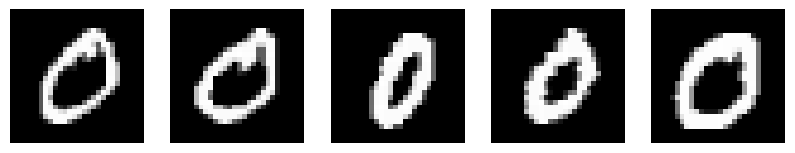

In [129]:
# Extract all images labeled as 0
zero_images = images[labels == 0]

# Display a few examples
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(zero_images[i], cmap='gray')
    ax.axis('off')
plt.show()

In [132]:
# Process a sample image of "0"
sample_st = image_to_simplicial_complex(zero_images[0])

# Print some simplicial structures
print("Simplices:", list(sample_st.get_simplices())[:10])  # Show first 10

Simplices: [([0, 1, 6], 0.0), ([0, 1, 7], 0.0), ([0, 1], 0.0), ([0, 5, 6], 0.0), ([0, 5], 0.0), ([0, 6, 7], 0.0), ([0, 6], 0.0), ([0, 7], 0.0), ([0], 0.0), ([1, 2, 7], 0.0)]


In [139]:
# Compute Betti numbers for the first image of "0"
sample_st.compute_persistence()
betti_numbers = sample_st.betti_numbers()
print("Betti-0 (Connected Components):", betti_numbers[0])
print("Betti-1 (Loops in the digit):", betti_numbers[1])

Betti-0 (Connected Components): 1
Betti-1 (Loops in the digit): 1


Average Betti-0: 1.04
Average Betti-1: 0.96


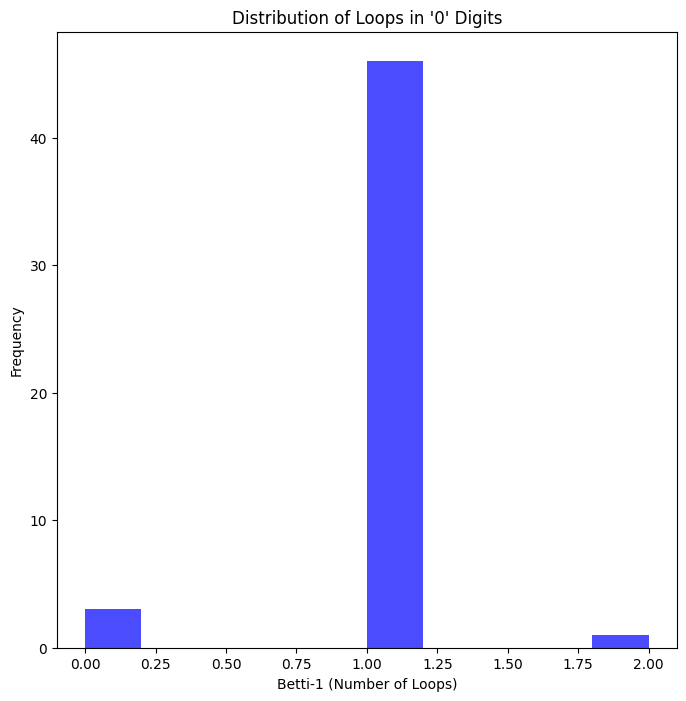

In [140]:
betti_0_list = []
betti_1_list = []

for i in range(50):  # Process 50 images of '0'
    st = image_to_simplicial_complex(zero_images[i])
    st.compute_persistence()
    betti_nums = st.betti_numbers()
    betti_0_list.append(betti_nums[0])
    betti_1_list.append(betti_nums[1])

# Analyze results
print("Average Betti-0:", np.mean(betti_0_list))  # Number of connected components
print("Average Betti-1:", np.mean(betti_1_list))  # Number of loops

# Histogram of Betti-1
plt.hist(betti_1_list, bins=10, alpha=0.7, color='blue')
plt.xlabel("Betti-1 (Number of Loops)")
plt.ylabel("Frequency")
plt.title("Distribution of Loops in '0' Digits")
plt.show()

In [157]:
from ripser import ripser
from persim import plot_diagrams

# Compute persistence diagram
pers = ripser(np.array(st.get_filtration()), maxdim=2)['dgms']

# Plot persistent homology
plot_diagrams(pers, show=True)


IndexError: tuple index out of range

In [154]:
next(st.get_filtration())

([0], 0.0)